
# # Hyperspectral Image Cleaning & Preprocessing

This notebook prepares hyperspectral data for classification experiments. Specifically, it covers the following steps:

- **Configuration**: Defines user-editable settings for paths, input files, and preprocessing options (such as band selection and PCA).
- **Data Loading**: Loads the hyperspectral image data cube and associated ground truth labels from `.mat` files or other formats.
- **Band Removal & PCA (optional)**: Optionally removes noisy or unwanted spectral bands and can apply PCA to reduce dimensionality.
- **Train/Val/Test Split**: Splits the labeled data into training, validation, and test sets using reproducible, stratified sampling.
- **Saving Artifacts**: Stores the cleaned/preprocessed blocks, split indices, and configuration for reproducible downstream analysis.
- **Preview Figures**: Saves visualizations for data inspection and QA.

By the end, you will have reproducibly prepared datasets and configuration for use in machine learning or deep learning models.


In [ ]:
# block  setup and folders
from pathlib import Path                                    # import Path for file paths
import json                                                 # import json to save config
import pickle                                               # import pickle to save objects
import numpy as np                                          # import numpy for arrays
import matplotlib.pyplot as plt                             # import matplotlib for plots

from dataclasses import dataclass, asdict                   # import dataclass tools for config
from typing import Optional, Tuple, Dict                    # import typing hints for clarity

from sklearn.model_selection import StratifiedShuffleSplit  # import stratified splitter for balanced splits
from sklearn.decomposition import PCA                       # import PCA for band reduction

try:                                                        # start try to import loadmat for mat files
    from scipy.io import loadmat                            # import loadmat to read mat files
except Exception:                                           # handle missing scipy
    loadmat = None                                          # set to None so npy paths still work

np.random.seed(42)                                          # fix global seed for basic reproducibility

ARTIFACTS = Path("outputs/artifacts_ip")                    # path where arrays and models are saved
FIGS = Path("outputs/figs")                                 # path where preview figures are saved
ARTIFACTS.mkdir(parents=True, exist_ok=True)                # create artifacts folder if missing
FIGS.mkdir(parents=True, exist_ok=True)                     # create figures folder if missing

In [ ]:
# block  configuration container and save helper
@dataclass                                                                    # declare dataclass for simple config
class Config:                                                                 # define configuration class
    """Config holds user editable settings for cleaning and preprocessing"""  # docstring for class
    data_root: str = "data"                                                   # folder that contains cube and labels
    cube_file: str = "Indian_pines_corrected.mat"                             # cube file name
    label_file: str = "Indian_pines_gt.mat"                                   # label file name
    cube_key: Optional[str] = "indian_pines_corrected"                        # key inside cube mat
    label_key: Optional[str] = "indian_pines_gt"                              # key inside labels mat

    remove_band_idx: Optional[list] = None                                    # list of band indices to drop or None
    split_train: float = 0.75                                                 # train fraction on labeled pixels
    split_val: float = 0.05                                                   # val fraction on labeled pixels
    split_test: float = 0.20                                                  # test fraction on labeled pixels
    split_seed: int = 42                                                      # seed for deterministic splits

    use_pca: bool = False                                                     # flag to enable PCA
    pca_components: int = 10                                                  # number of components for PCA

    outputs_root: str = ARTIFACTS.as_posix()                                  # artifacts folder path
    preview_figs: str = FIGS.as_posix()                                       # figures folder path

    def save(self, path: Path) -> None:                                       # define method to save config
        """Save configuration as json to the given path"""                    # docstring for method
        path.parent.mkdir(parents=True, exist_ok=True)                        # ensure folder exists
        with open(path, "w") as f:                                            # open file for writing
            json.dump(asdict(self), f, indent=2)                              # write json with indentation

cfg = Config()                                                                # create a config instance with defaults
cfg.save(ARTIFACTS / "config_clean_preprocess.json")                          # save config for traceability
cfg                                                                           # show config in notebook output for quick check

Config(data_root='data', cube_file='Indian_pines_corrected.mat', label_file='Indian_pines_gt.mat', cube_key='indian_pines_corrected', label_key='indian_pines_gt', remove_band_idx=None, split_train=0.75, split_val=0.05, split_test=0.2, split_seed=42, use_pca=False, pca_components=10, outputs_root='outputs/artifacts_ip', preview_figs='outputs/figs')

In [ ]:
# block  simple preview plot
def quick_false_color(cube: np.ndarray, bands=(10, 30, 60), out_path: Optional[Path] = None) -> None:
    """Draw a false color image from three bands and save if a path is given"""                        # docstring
    b0 = max(0, min(cube.shape[2] - 1, bands[0]))                                                      # clamp first band index
    b1 = max(0, min(cube.shape[2] - 1, bands[1]))                                                      # clamp second band index
    b2 = max(0, min(cube.shape[2] - 1, bands[2]))                                                      # clamp third band index
    img = cube[:, :, [b0, b1, b2]]                                                                     # slice three band channels
    img = img - img.min(axis=(0, 1), keepdims=True)                                                    # shift to zero per channel
    img = img / (img.max(axis=(0, 1), keepdims=True) + 1e-8)                                           # scale to one per channel
    plt.figure(figsize=(4, 4))                                                                         # create figure
    plt.imshow(img)                                                                                    # show image
    plt.title(f"False color bands [{b0}, {b1}, {b2}]")                                                 # set title with bands
    plt.axis("off")                                                                                    # hide axes
    plt.tight_layout()                                                                                 # tidy layout
    if out_path is not None:                                                                           # if saving is requested
        out_path.parent.mkdir(parents=True, exist_ok=True)                                             # ensure folder exists
        plt.savefig(out_path, dpi=150)                                                                 # save png
        plt.close()                                                                                    # close figure to free memory
    else:                                                                                              # else just display
        plt.show()                                                                                     # show figure inline

In [ ]:
 # block  data loading from mat or npy
def load_cube_and_labels(cfg: Config) -> Tuple[np.ndarray, np.ndarray]:
    """Load hyperspectral cube and label map using cfg paths and keys"""             # docstring
    cube_path = Path(cfg.data_root) / cfg.cube_file                                  # build cube path
    lab_path = Path(cfg.data_root) / cfg.label_file                                  # build labels path

    if cube_path.suffix == ".npy":                                                   # check for numpy file
        cube = np.load(cube_path)                                                    # load cube as numpy array
    else:                                                                            # assume mat file
        assert loadmat is not None, "scipy is required for mat files"                # guard for missing scipy
        md = loadmat(cube_path)                                                      # read mat file into dict
        key = cfg.cube_key or next(k for k in md.keys() if not k.startswith("__"))   # pick key if not set
        cube = md[key]                                                               # extract matrix by key

    if lab_path.suffix == ".npy":                                                    # check for numpy labels
        labels = np.load(lab_path)                                                   # load labels as numpy array
    else:                                                                            # assume mat file for labels
        assert loadmat is not None, "scipy is required for mat files"                # guard for missing scipy
        md = loadmat(lab_path)                                                       # read labels mat file
        key = cfg.label_key or next(k for k in md.keys() if not k.startswith("__"))  # pick label key
        labels = md[key]                                                             # extract label matrix

    cube = np.asarray(cube)                                                          # ensure numpy array
    labels = np.asarray(labels)                                                      # ensure numpy array
    assert cube.ndim == 3, "cube must be H W B"                                      # validate cube dims
    assert labels.ndim == 2, "labels must be H W"                                    # validate label dims
    assert cube.shape[:2] == labels.shape, "spatial sizes must match"                # validate shapes
    return cube, labels                                                              # return arrays

cube_raw, labels_raw = load_cube_and_labels(cfg)                                     # load datasets
H, W, B = cube_raw.shape                                                             # unpack shape for quick use
print("Loaded", cube_raw.shape, "labels", labels_raw.shape)                          # print shapes
quick_false_color(cube_raw, out_path=FIGS / "false_color_raw.png")                   # save a quick preview

Loaded (145, 145, 200) labels (145, 145)


In [ ]:
# block  drop noisy bands if requested
def remove_bands(cube: np.ndarray, idx_list: Optional[list]) -> Tuple[np.ndarray, np.ndarray]:
    """Remove selected band indices and return filtered cube and keep mask"""                   # docstring
    B = cube.shape[2]                                                                           # number of bands
    keep = np.ones(B, dtype=bool)                                                               # init keep mask as all True
    if idx_list:                                                                                # if there are bands to drop
        idx = np.array(idx_list, dtype=int)                                                     # convert to numpy ints
        idx = idx[(idx >= 0) & (idx < B)]                                                       # keep only valid indices
        keep[idx] = False                                                                       # mark those indices as False
    return cube[:, :, keep], keep                                                               # return filtered cube and keep mask

cube_clean, keep_mask = remove_bands(cube_raw, cfg.remove_band_idx)                             # apply band removal
kept_bands = np.nonzero(keep_mask)[0].tolist()                                                  # convert mask to band list
with open(ARTIFACTS / "kept_bands.json", "w") as f:                                             # open json file to save
    json.dump({"kept_band_indices": kept_bands}, f, indent=2)                                   # save kept band indices
print("Kept bands", len(kept_bands), "of", B)                                                   # print kept band count

Kept bands 200 of 200


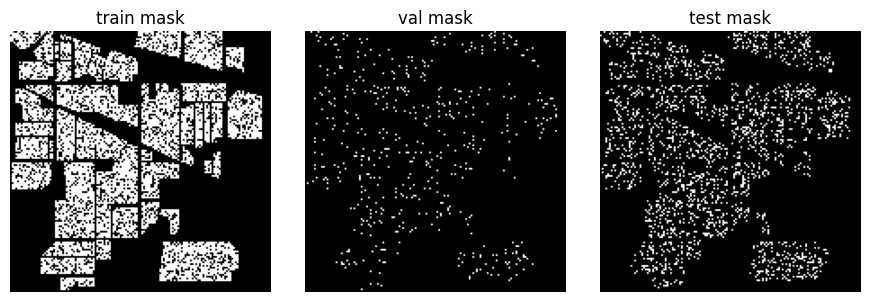

Split counts
train 7686
val 513
test 2050


In [ ]:
# block  pixel wise stratified splitting
# We use stratified splits to keep class ratios similar in train, val, and test so results are fair Indian Pines is imbalanced,
# so this ensures rare classes appear in each split This makes metrics and tuning more stable and comparable across runs

def make_stratified_masks(labels: np.ndarray,
                          train: float,
                          val: float,
                          test: float,
                          seed: int = 42) -> Dict[str, np.ndarray]:
    """Create boolean masks for train val test using labeled pixels only"""                                # docstring
    assert abs(train + val + test - 1.0) < 1e-6, "splits must sum to one"                                  # check fractions sum
    H, W = labels.shape                                                                                    # get spatial size
    y_flat = labels.ravel()                                                                                # flatten labels
    idx_all = np.where(y_flat > 0)[0]                                                                      # indices of labeled pixels
    y_lab = y_flat[idx_all]                                                                                # class ids for labeled pixels

    sss1 = StratifiedShuffleSplit(n_splits=1, test_size=test, random_state=seed)                           # first split into trainval and test
    trainval_idx, test_idx = next(sss1.split(idx_all, y_lab))                                              # run first split
    idx_trainval = idx_all[trainval_idx]                                                                   # indices for trainval group
    idx_test = idx_all[test_idx]                                                                           # indices for test group
    y_trainval = y_flat[idx_trainval]                                                                      # class ids for trainval group

    val_in_trainval = val / (train + val)                                                                  # compute validation fraction within trainval
    sss2 = StratifiedShuffleSplit(n_splits=1, test_size=val_in_trainval, random_state=seed + 1)            # second split
    tr_idx, va_idx = next(sss2.split(idx_trainval, y_trainval))                                            # run second split
    idx_train = idx_trainval[tr_idx]                                                                       # indices for train set
    idx_val = idx_trainval[va_idx]                                                                         # indices for validation set

    mask_train = np.zeros(H * W, dtype=bool)                                                               # init flat train mask
    mask_val = np.zeros(H * W, dtype=bool)                                                                 # init flat val mask
    mask_test = np.zeros(H * W, dtype=bool)                                                                # init flat test mask
    mask_train[idx_train] = True                                                                           # mark train indices
    mask_val[idx_val] = True                                                                               # mark val indices
    mask_test[idx_test] = True                                                                             # mark test indices

    return {                                                                                               # return masks as H by W arrays
        "train": mask_train.reshape(H, W),                                                                 # train mask
        "val": mask_val.reshape(H, W),                                                                     # val mask
        "test": mask_test.reshape(H, W),                                                                   # test mask
    }                                                                                                      # end dict

masks = make_stratified_masks(labels_raw, cfg.split_train, cfg.split_val, cfg.split_test, cfg.split_seed)  # build masks
np.save(ARTIFACTS / "mask_train.npy", masks["train"])                                                      # save train mask
np.save(ARTIFACTS / "mask_val.npy", masks["val"])                                                          # save val mask
np.save(ARTIFACTS / "mask_test.npy", masks["test"])                                                        # save test mask

plt.figure(figsize=(9, 3))                                                                                 # create figure for mask previews
for i, k in enumerate(["train", "val", "test"]):                                                           # loop over split names
    plt.subplot(1, 3, i + 1)                                                                               # add subplot
    plt.imshow(masks[k], cmap="gray")                                                                      # show mask image
    plt.title(f"{k} mask")                                                                                 # set title
    plt.axis("off")                                                                                        # hide axes
plt.tight_layout()                                                                                         # tidy layout
plt.savefig(FIGS / "masks_preview.png", dpi=150)                                                           # save preview figure
plt.show()                                                                                                 # display figure

print("Split counts")                                                                                      # print header
for k in ["train", "val", "test"]:                                                                         # loop through splits
    print(k, int(masks[k].sum()))                                                                          # print labeled pixel count per split

In [ ]:
# Z score scales each band to zero mean and unit variance using train statistics only
# For each band b, x_hat equals x minus mean_b, then divide by std_b plus a tiny epsilon to avoid divide by zero
# This keeps features comparable across bands and improves training stability without leaking info from val or test

# block  z score normalization
def fit_zscore_on_train(cube: np.ndarray, mask_train: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Fit per band mean and std on train pixels only for z score scaling"""                         # docstring
    X = cube[mask_train]                                                                             # gather train pixels as N by B
    mean = X.mean(axis=0)                                                                            # compute mean per band
    std = X.std(axis=0) + 1e-8                                                                       # compute std per band with small epsilon
    return mean, std                                                                                 # return stats

def apply_zscore(cube: np.ndarray, mean: np.ndarray, std: np.ndarray) -> np.ndarray:
    """Apply z score normalization to full cube with given mean and std"""                           # docstring
    return (cube - mean) / std                                                                       # vectorized normalization

mean_b, std_b = fit_zscore_on_train(cube_clean, masks["train"])                                      # fit stats on train only
cube_norm = apply_zscore(cube_clean, mean_b, std_b)                                                  # normalize the full cube
with open(ARTIFACTS / "scaler.pkl", "wb") as f:                                                      # open file to save scaler
    pickle.dump({"mean": mean_b, "std": std_b}, f)                                                   # dump scaler dict
quick_false_color(cube_norm, bands=(5, 25, 50), out_path=FIGS / "false_color_norm.png")              # save normalized preview
print("Z score done")                                                                                # confirm step

Z score done


In [ ]:
# block  PCA on train pixels then transform full image
# PCA reduces bands by projecting spectra to a smaller set of components that keep most variance
# We fit PCA on train pixels only to learn the projection and avoid leaking info from val or test
 # We then transform the whole cube with this projection to get a compact cube that is faster and less noisy

def fit_pca_on_train(cube: np.ndarray, mask_train: np.ndarray, n_components: int, seed: int) -> Tuple[PCA, np.ndarray]:
    """Fit PCA on train pixel spectra and return model and variance ratios"""                                            # docstring
    B = cube.shape[2]                                                                                                    # number of bands
    K = min(n_components, B)                                                                                             # clip components to band count
    X = cube[mask_train]                                                                                                 # train pixels as N by B
    pca = PCA(n_components=K, svd_solver="auto", whiten=False, random_state=seed)                                        # create PCA object
    pca.fit(X)                                                                                                           # fit PCA on train data
    return pca, pca.explained_variance_ratio_                                                                            # return PCA and EVR

def apply_pca_full_image(cube: np.ndarray, pca: PCA) -> np.ndarray:
    """Apply fitted PCA to full cube and reshape back to H W K"""                                                        # docstring
    H, W, B = cube.shape                                                                                                 # unpack dims
    X = cube.reshape(-1, B)                                                                                              # flatten spatial dims
    Xp = pca.transform(X)                                                                                                # apply PCA transform
    return Xp.reshape(H, W, Xp.shape[1])                                                                                 # reshape to cube

if cfg.use_pca and cfg.pca_components > 0:                                                                               # check PCA flag
    pca_obj, evr = fit_pca_on_train(cube_norm, masks["train"], cfg.pca_components, cfg.split_seed)                       # fit PCA
    cube_pca = apply_pca_full_image(cube_norm, pca_obj)                                                                  # transform full cube
    with open(ARTIFACTS / "pca.pkl", "wb") as f:                                                                         # open file to save PCA
        pickle.dump({"pca": pca_obj}, f)                                                                                 # dump PCA object
    np.save(ARTIFACTS / "pca_explained_variance_ratio.npy", evr)                                                         # save EVR array

    plt.figure(figsize=(4, 3))                                                                                           # create figure for EVR plot
    plt.plot(np.cumsum(evr), marker="o")                                                                                 # plot cumulative EVR
    plt.xlabel("Components")                                                                                             # set x label
    plt.ylabel("Cumulative explained variance")                                                                          # set y label
    plt.grid(True, linestyle=":")                                                                                        # add light grid
    plt.tight_layout()                                                                                                   # tidy layout
    plt.savefig(FIGS / "pca_explained_variance.png", dpi=150)                                                            # save plot
    plt.show()                                                                                                           # display plot
    print("PCA done shape", cube_pca.shape)                                                                              # report PCA cube shape
else:                                                                                                                    # PCA not used
    cube_pca = None                                                                                                      # set to None so later code can check
    print("PCA skipped")                                                                                                 # report that PCA is skipped

PCA skipped


In [ ]:
# block  save artifacts and print counts
np.save(ARTIFACTS / "cube_clean_norm.npy", cube_norm.astype(np.float32))   # save normalized cube
np.save(ARTIFACTS / "labels.npy", labels_raw.astype(np.int32))             # save labels array
if cube_pca is not None:                                                   # if PCA exists
    np.save(ARTIFACTS / "cube_pca.npy", cube_pca.astype(np.float32))       # save PCA cube

def class_counts(labels: np.ndarray, mask: np.ndarray) -> Dict[int, int]:
    """Return dict of class id to count for pixels under mask"""           # docstring
    y = labels[mask]                                                       # select masked labels
    vals, cnts = np.unique(y[y > 0], return_counts=True)                   # count classes ignoring background
    return {int(v): int(c) for v, c in zip(vals, cnts)}                    # build dict

for k in ["train", "val", "test"]:                                         # loop splits
    print(k, class_counts(labels_raw, masks[k]))                           # print per class counts

train {1: 35, 2: 1071, 3: 622, 4: 178, 5: 362, 6: 547, 7: 22, 8: 358, 9: 15, 10: 729, 11: 1841, 12: 444, 13: 154, 14: 949, 15: 290, 16: 69}
val {1: 2, 2: 71, 3: 42, 4: 12, 5: 24, 6: 37, 7: 1, 8: 24, 9: 1, 10: 49, 11: 123, 12: 30, 13: 10, 14: 63, 15: 19, 16: 5}
test {1: 9, 2: 286, 3: 166, 4: 47, 5: 97, 6: 146, 7: 5, 8: 96, 9: 4, 10: 194, 11: 491, 12: 119, 13: 41, 14: 253, 15: 77, 16: 19}


In [ ]:
# block  final summary print
print("=== Summary ===")                                                 # header line
print("Cube raw", cube_raw.shape)                                        # raw cube shape
print("Cube clean norm", cube_norm.shape)                                # normalized cube shape
if cube_pca is not None:                                                 # if PCA was computed
    print("Cube PCA", cube_pca.shape, "components", cfg.pca_components)  # PCA cube shape
print("Labels", labels_raw.shape)                                        # labels shape
for k in ["train", "val", "test"]:                                       # loop splits
    print(k, int(masks[k].sum()), "labeled pixels")                      # pixel counts per split
print("Artifacts folder", ARTIFACTS.as_posix())                          # artifacts path
print("Preview figs folder", FIGS.as_posix())                            # figures path

=== Summary ===
Cube raw (145, 145, 200)
Cube clean norm (145, 145, 200)
Labels (145, 145)
train 7686 labeled pixels
val 513 labeled pixels
test 2050 labeled pixels
Artifacts folder outputs/artifacts_ip
Preview figs folder outputs/figs
